In [1]:
import pandas as pd 
import numpy as np 

import anndata
import scanpy as sc 


In [2]:
adata = anndata.read_csv('../files/Tsukahara_2021/GSE173947_envA_bidirectional_switch_umi_counts.csv')
meta = pd.read_csv('../files/Tsukahara_2021/GSE173947_envA_bidirectional_switch_metadata.csv', index_col = 0 )

# Combine metadata 
adata.obs = adata.obs.merge(meta, left_index = True, 
                            right_index = True)
# store a raw copy 
raw_adata = adata.copy()


### TODO Tasks 
- identify the change in ORs expression across the change of environment
- create category bins for up-regulated, no-change, and down-regulated via change of environment 
- Observe the change of Rhbdf2 and associated genes if there are consistent patterns across bins 

In [3]:
# Restart adata 
adata = raw_adata.copy()

In [4]:
# Basic preprocessing steps
sc.pp.filter_cells(adata, min_genes=200)  # Filter cells with fewer than 200 expressed genes
sc.pp.filter_genes(adata, min_cells=3)  # Filter genes expressed in fewer than 3 cells

# Calculate QC metrics
# SKIPPING mt filter as the data does not contain any mt genes 
# adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#              jitter=0.4, multi_panel=True) 
# Filter high mt cells 
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :]

# Normalize counts 
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize counts

# log-transform
# sc.pp.log1p(adata) 

# Scale the data
# sc.pp.scale(adata, max_value=10)

In [5]:
# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

sc.tl.leiden(adata)

# Perform UMAP
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'top_Olfr' as categorical
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_ident' as categorical
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a fu

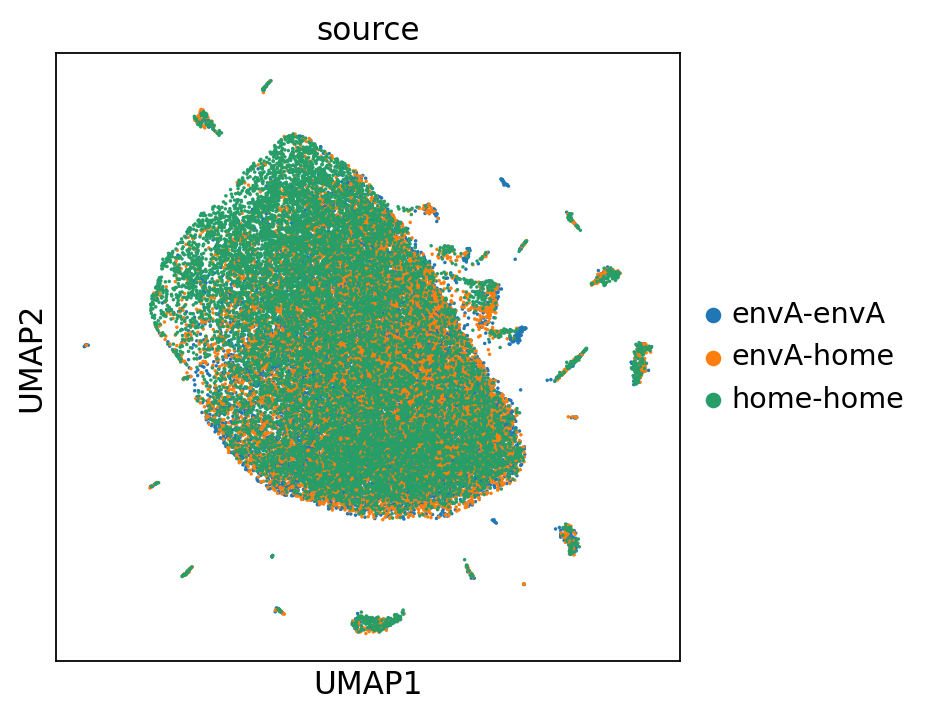

In [6]:
# Plot UMAP
sc.set_figure_params(figsize = [5,5], facecolor = 'white')
sc.pl.umap(adata, color = ['source'], size = 10)

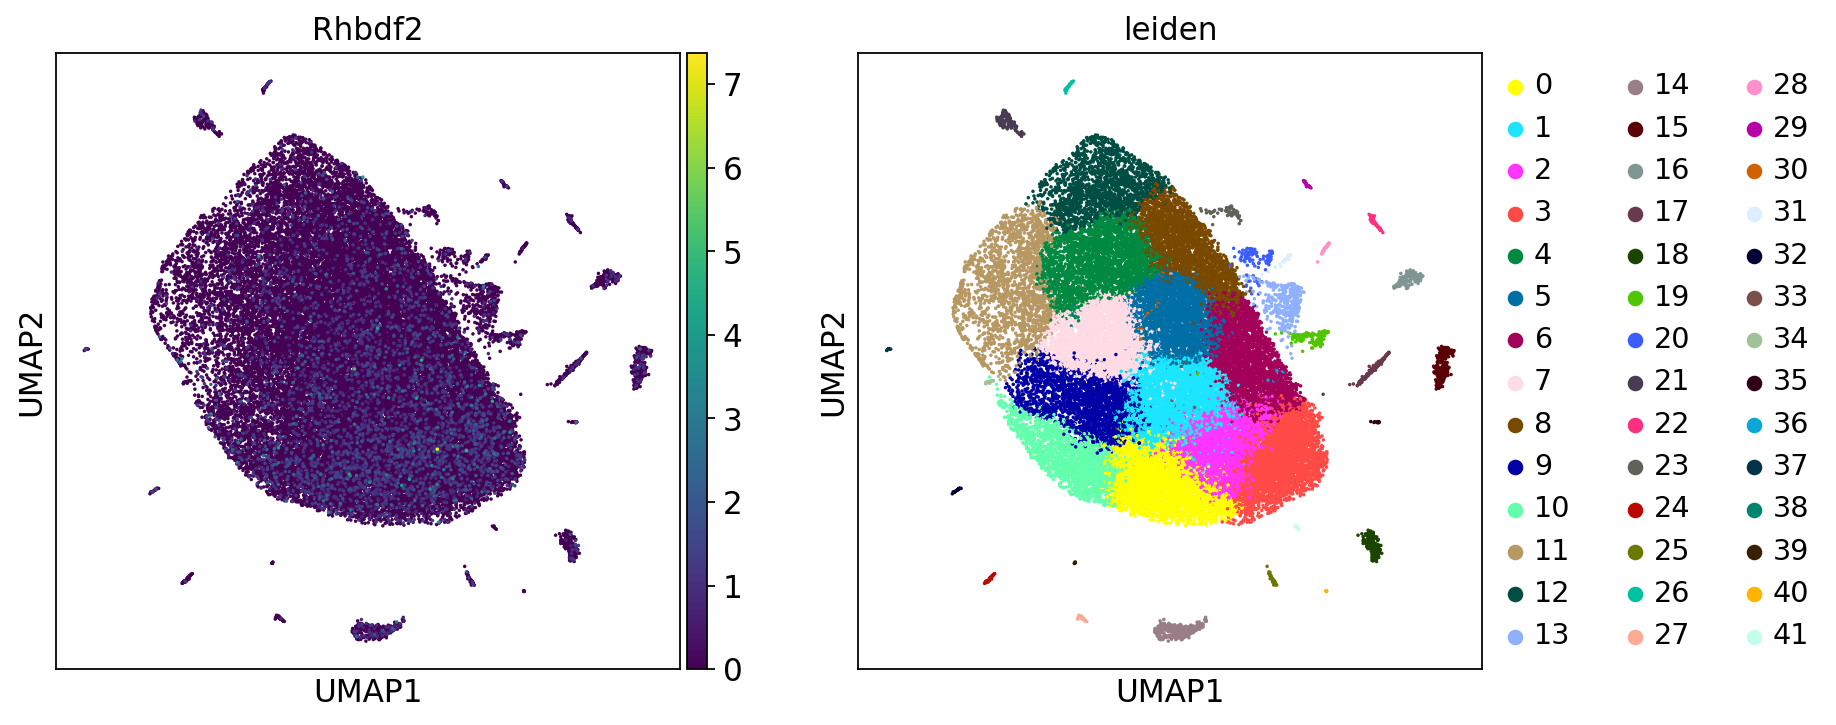

In [7]:
sc.pl.umap(adata, color = ['Rhbdf2', 'leiden'], size = 10)

In [47]:
from scipy.stats import ttest_ind

top_Olfr = [Olfr for Olfr in adata.obs.top_Olfr.unique() if 'Olfr' in Olfr]
environments = adata.obs.source.unique()

results = pd.DataFrame()
for i in range(len(environments)):
    for j in range(i+1, len(environments)):
        
        env1 = environments[i]
        env2 = environments[j]
        
        # Subset the data for the two sources
        adata_subset = adata[adata.obs['source'].isin([env1, env2])].copy()
        
        # Filter genes based on the gene_subset
        for Olfr in top_Olfr:
            try: 
                # Subset the genes to selected Olfr
                adata_subset_Olfr = adata_subset[:, Olfr]
                # Subset cells to selected Olfr 
                adata_subset_Olfr = adata_subset_Olfr[(adata_subset_Olfr.obs.top_Olfr == Olfr)]
                
                # Check if Olfr is in present in both environments adata if not skip 
                if not len(adata_subset_Olfr.obs.env.unique()) == 2:
                    continue 
                
                
                # Extract Olfr reads 
                env1_Olfr = adata_subset_Olfr[adata_subset_Olfr.obs.source == env1].X
                env2_Olfr = adata_subset_Olfr[adata_subset_Olfr.obs.source == env2].X
                
                # Calculate the mean of Olfr expression across cells in different environment
                env1_Olfr_mean = env1_Olfr.mean()
                env2_Olfr_mean = env2_Olfr.mean()

                # Calculate fold change of mean Olfr expression between environments
                foldchange = float(env1_Olfr_mean / env2_Olfr_mean)
                
                # Perform t-test, 
                t_stat, p_value = ttest_ind(env1_Olfr, env2_Olfr)
                
                # Store the result in a result df 
                result_df = pd.DataFrame([[Olfr, 
                                           f'{env1}_{env2}', 
                                           foldchange, 
                                           t_stat[0], 
                                           p_value[0]]], 
                                        columns=['Olfr', 
                                                 'env_change', 
                                                 'FoldChange',
                                                 't_stat',
                                                 'p_value'])
                results = pd.concat([results, result_df])
            except: 
                # print(f'{Olfr} skipped')
                continue 


# adata_subset_Olfr = adata_subset[:, 'Olfr1018']
# adata_subset_Olfr = adata_subset_Olfr[(adata_subset_Olfr.obs.top_Olfr == 'Olfr1018')]


/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [59]:
# Filter out Olfr present in only one cell 
results = results[~np.isnan(results.t_stat)]

<AxesSubplot:>

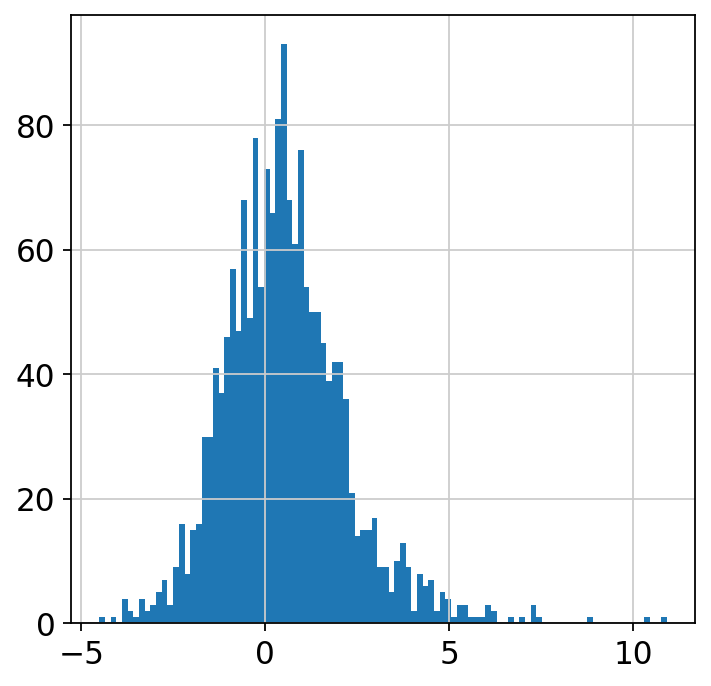

In [60]:
results.t_stat.hist(bins=100)

In [61]:
results.sort_values('t_stat')

,Olfr,env_change,FoldChange,t_stat,p_value
0,Olfr1509,envA-envA_home-home,0.767931,-4.505641,1.397994e-05
0,Olfr1111,envA-envA_envA-home,0.678392,-4.159174,7.390005e-04
0,Olfr55,envA-envA_home-home,0.829968,-3.803001,1.820923e-04
0,Olfr1065,envA-envA_envA-home,0.675431,-3.784620,1.163533e-03
0,Olfr728,envA-envA_home-home,0.886857,-3.772777,2.028750e-04
...,...,...,...,...,...
0,Olfr1427,envA-envA_home-home,1.483307,7.362125,5.102724e-09
0,Olfr734,envA-envA_home-home,2.578068,7.494586,1.287344e-08
0,Olfr309,envA-envA_home-home,1.854217,8.859407,5.731199e-14
0,Olfr1018,envA-envA_home-home,3.620719,10.429050,1.212729e-14
